In [3]:
'''
Aim: prepare panels of figure 4 in the manuscript
Date: Oct/2023
Author: Yike Xie
'''

'\nAim: prepare panels of figure 4 in the manuscript\nDate: Oct/2023\nAuthor: Yike Xie\n'

optical features vs gene expression has been done in figure 2 [spectra_norm vs gene exp]

In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [5]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [6]:
# load dataset
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/PCA_live/'

load features
load dataset
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [7]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## PCA on 15 pectras and select components with high variances

In [12]:
if False:
    
    from sklearn.decomposition import PCA
    live_df = df.loc[live_cells]
    
    X = live_df.values
    pca = PCA()
    X_r = pca.fit(X).transform(X)


    PCA_df = pd.DataFrame(X_r, index=live_df.index, columns=['PC{}'.format(str(i + 1)) for i in range(15)])
    PCA_df.loc['exp_var'] = pca.explained_variance_ratio_
    PCA_df.to_csv(save_figures + 'PCA_15PC.tsv', sep='\t')
    
    components = pd.DataFrame(pca.components_, index=['PC{}'.format(str(i)) for i in range(1, 16)],
             columns=adata.obs['wavelengths'].iloc[0])
    components.to_csv(save_figures + 'PCA_components.tsv', sep='\t')

In [13]:
## load the analyses results
components = pd.read_csv(save_figures + 'PCA_components.tsv', sep='\t', index_col=0)
X_r = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t')

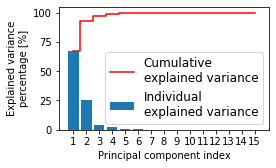

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
X = live_df.values
pca = PCA()
X_r = pca.fit(X).transform(X)
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=[4, 2.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12
ax.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual\nexplained variance')
ax.step(range(1, len(exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative\nexplained variance', color='red')

ax.set_ylabel('Explained variance\npercentage [%]')
ax.set_xlabel('Principal component index')
ax.set_xticks(ticks=range(1, len(exp_var) + 1))
ax.legend(loc='best', fontsize=12)
fig.tight_layout()
fig.savefig(save_figures + 'PCA_exp_vars_live.pdf', dpi=300, bbox_inches='tight')
fig.savefig(save_figures + 'PCA_exp_vars_live.png', dpi=300, bbox_inches='tight')

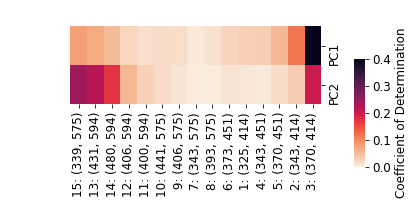

In [15]:
PCA_df = pow(components.loc[['PC1', 'PC2']], 2).T.clip(0, 0.4)
idx = PCA_df[8:].sort_values('PC2', ascending=False).index.tolist() + PCA_df[:8].sort_values('PC1').index.tolist()
wl_index = [i for i in idx]
PCA_df = PCA_df.loc[wl_index]
index = [['', ' '][list(components.columns).index(i) + 1 < 10] + str(list(components.columns).index(i) + 1) + ': ' + i 
         for i in wl_index]
PCA_df.index = index

rcParams['pdf.fonttype'] = 42
g = sns.clustermap(PCA_df.T, col_cluster=False, row_cluster=False,
                vmin=0, vmax=0.4, cbar_pos=[1, 0.2, 0.03, 0.5],
                cbar_kws={'label':'Coefficient of Determination'}, cmap='rocket_r',
                figsize=[5, 3])
# g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R.pdf', dpi=150, bbox_inches='tight')

In [16]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)
data = PCA_df[:-1][['PC1', 'PC2']]/10e3

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'ls', 'lw'
  cset = contour_func(


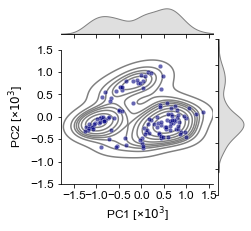

In [21]:
## kde plot with live and dead cells
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"

g = sns.JointGrid(data=data, x='PC1', y='PC2')

g.plot_joint(sns.scatterplot, s=20, facecolor='navy', edgecolor='white', alpha=0.6)

g.plot_joint(sns.kdeplot, zorder=-1, color='gray', ls='--', lw=1)
g.plot_marginals(sns.kdeplot, cmap='tab10', fill=True, bw_method=0.3, color='gray')

g.ax_joint.set_aspect('equal', adjustable='box')
g.ax_joint.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
               xlim=[-1.8, 1.6], ylim=[-1.5, 1.5])
g.ax_joint.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
g.ax_joint.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

## add colors to different groups
# g.ax_joint.scatter(data.loc[live_cells]['PC1'], data.loc[live_cells]['PC2'], s=20, 
#                    facecolor='green', edgecolor='w', alpha=0.6, 
#                    label='Low')

# g.ax_joint.scatter(data.loc[dead_cells]['PC1'], data.loc[dead_cells]['PC2'], s=20, 
#                    facecolor='deeppink', edgecolor='w', alpha=0.6, 
#                    label='High')

# g.ax_joint.legend(bbox_to_anchor=[1.2, 1], title='Percentage\nof MT- genes')

figure = plt.gcf()
figure.set_size_inches(3, 3)

figure.savefig(save_figures + 'kde_pct_MT.png', dpi=300, bbox_inches='tight')
figure.savefig(save_figures + 'kde_pct_MT.pdf', dpi=300, bbox_inches='tight')

## I tried to separate these cells into two parts: upper cells and lower cells
# lower_cells = data[data['PC2'] + data['PC1'] * 4/7 < 1/7].index.tolist() # 44.54 % dead cells
# upper_cells = data[data['PC2'] + data['PC1'] * 4/7 > 1/7].index.tolist() # 96.36 % live cells

In [28]:
import gseapy as gp
from gseapy.plot import barplot

def gsea_analysis(genes, path, fn, title):
    res = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
    if fn is not False:
        res.res2d.to_csv(os.path.join(path, fn + '.tsv'), sep='\t')

    barplot(res.res2d, column='P-value', title=title, ofname=os.path.join(path, fn + '.svg')) 